In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext lab_black

In [3]:
import torch
from torch import optim
import torch.nn as nn
from torch.nn import functional as F

from IPython.display import clear_output
from IPython.core.debugger import set_trace

import matplotlib.pyplot as plt
import pickle
import copy
import math

import dlc_practical_prologue as dl

from misc_funcs import RANDOM_SEED, EXPLORE_K, BIG_K, NB_EPOCHS, sep

# WeightAux

The project respects the following structure:
Simple Network:
```
    .
    ├── Simple Network               
    │   ├── Net2    
    │   ├── get_accuracy()         
    │   ├── train_model()  
    │   ├── Kfold_CV()
    ├── Double Network
    │   ├── Naive
    │   ├── WeightAux
    │   ├── accuracy_double_model()   
    │   ├── train_double_model()   
    │   ├── Kfold_CVdouble()

```

In [4]:
train_input, train_target, test_input, test_target = dl.load_data(flatten=False)
train_input = torch.functional.F.avg_pool2d(train_input, kernel_size=2)
test_input = torch.functional.F.avg_pool2d(test_input, kernel_size=2)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


## Simple Network Implementation

<div class="alert alert-block alert-info">
We start by implementing a simple handmade-optimized CNN that performs decently on the MNIST dataset (nets.Net2): we will use it as the reference throuhghout the project for comparison purposes.
</div>

In [18]:
from opt import (
    Net2,
    train_model,
    get_accuracy,
    Kfold_CV,
    Naive,
    WeightAux,
    get_double_accuracy,
    train_double_model,
    Kfold_CVdouble,
)

In [19]:
model = Net2()
architecture = Net2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam
lr = 1e-3
train_model(
    train_input,
    train_target,
    model,
    criterion=criterion,
    optimizer=optimizer,
    lr=lr,
    verbose=True,
)
print(sep)
_ = get_accuracy(model, train_input, train_target, "Train")
_ = get_accuracy(model, test_input, test_target, "Test")
print(sep)

Progression:90.00 %
--------------------
Train accuracy: 1.00
Test accuracy: 0.94
--------------------


<div class="alert alert-block alert-info">
As we can see, the model overfits on the train set and performs well enough for the comparison purpose, although some parameter tuning could probably get this accuracy higher.
</div>

<div class="alert alert-block alert-info">
In order to get more robust estimates, a KFold Cross validation method was implemented as well
</div>

In [20]:
accuracies = Kfold_CV(
    train_input, train_target, architecture, criterion, optimizer, lr, K=4, verbose=True
)

--------------------
Accuracies for 4-fold:[0.9399999976158142, 0.9240000247955322, 0.9399999976158142, 0.9520000219345093]
Mean accuracy:0.9390000104904175
--------------------


## Dealing with double Images

<div class="alert alert-block alert-info">
We now implement 4 different model architectures in order to assess the performance improvement that can be achieved through weight sharing or auxiliary loss. 
    
* Naive model, where we just train 2 networks in parallel and trivially compare the output
* Weight Sharing
* Auxiliary loss
* Auxiliary loss + Weight sharing
</div>

In [21]:
N_SAMPLES = 500
a, b, c, d = dl.load_data(flatten=False)
train2_input, train2_target, train2_classes = dl.mnist_to_pairs(N_SAMPLES, a, b)
test2_input, test2_target, test2_classes = dl.mnist_to_pairs(N_SAMPLES, c, d)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


### Models

### Implementations

<div class="alert alert-block alert-info">
First a by-hand optimized version of the baseline
</div>

In [22]:
# Parameters definition
criterion = nn.CrossEntropyLoss
optimizer = optim.Adam
lr = 1e-3
naive_baseline = Naive()
############################

In [23]:
train_double_model(
    train2_input,
    train2_target,
    train2_classes,
    naive_baseline,
    criterion,
    optimizer,
    lr,
    nb_epochs=25,
    verbose=True,
)
print(sep + "Train" + sep)
_ = accuracy_double_model(
    naive_baseline, train2_input, train2_target, train2_classes, verbose=True
)
print(sep + "Test" + sep)
_ = accuracy_double_model(
    naive_baseline, test2_input, test2_target, test2_classes, verbose=True
)

Progression:96.00 %
--------------------Train--------------------
Accuracy 1st Network:    1.00   
Accuracy 2nd Network:    1.00   
Accuracy comparison:     1.00    
--------------------Test--------------------
Accuracy 1st Network:    0.92   
Accuracy 2nd Network:    0.91   
Accuracy comparison:     0.95    


<div class="alert alert-block alert-info">
More robust metric:
</div>

In [24]:
_ = Kfold_CVdouble(
    train2_input,
    train2_target,
    train2_classes,
    Naive(),
    criterion,
    optimizer,
    lr,
    K=2,
    verbose=True,
)

--------------------Validation Accuracies for 2-fold:--------------------
Accuracy 1st network: 0.90 +- 0.01
Accuracy 2nd network: 0.90 +- 0.01
Accuracy comparison:  0.92 +- 0.01


<div class="alert alert-block alert-info">
And an equivalent with both the weight sharing and the auxiliary losses activated
</div>

In [25]:
# Parameters definition
criterion = nn.CrossEntropyLoss
optimizer = optim.Adam
lr = 1e-3
lambda_ = 0.75
net2 = WeightAux(True, True)
############################

In [26]:
train_double_model(
    train2_input,
    train2_target,
    train2_classes,
    net2,
    criterion,
    optimizer,
    lr,
    lambda_,
    nb_epochs=25,
    verbose=True,
)
print(sep + "Train accuracy:" + sep)
_ = accuracy_double_model(
    net2, train2_input, train2_target, train2_classes, verbose=True
)
print(sep + "Test accuracy:" + sep)
_ = accuracy_double_model(net2, test2_input, test2_target, test2_classes, verbose=True)

Progression:96.00 %
--------------------Train accuracy:--------------------
Accuracy 1st Network:    1.00   
Accuracy 2nd Network:    1.00   
Accuracy comparison:     1.00    
--------------------Test accuracy:--------------------
Accuracy 1st Network:    0.93   
Accuracy 2nd Network:    0.93   
Accuracy comparison:     0.83    


<div class="alert alert-block alert-info">
And for the WeightSharing
</div>

In [27]:
acc_list = Kfold_CVdouble(
    train2_input,
    train2_target,
    train2_classes,
    WeightAux(True, True),
    criterion,
    optimizer,
    lr,
    lambda_,
    K=2,
    verbose=True,
)

--------------------Validation Accuracies for 2-fold:--------------------
Accuracy 1st network: 0.92 +- 0.01
Accuracy 2nd network: 0.91 +- 0.02
Accuracy comparison:  0.75 +- 0.03


# Hyperparameter Optimization

<div class="alert alert-block alert-info">
In order to improve the models mentionned above 2 types of hyperparameters optimization method were implemented:
    
* Grid Search
* Genetic Algorithm
    
Both of these methods rely on the following param class which allow intuitive subsequent optimization.
</div>

In [28]:
# local
from hyperopt import Param, HyperGrid, GetNTop, GetMax
from gridsearch import GridSearch

In [29]:
# 1 Architecture
Archis = [
    WeightAux(True, True),
    WeightAux(True, False),
    WeightAux(False, True),
    WeightAux(False, False),
]
# 2 Comparison Loss Function
CompLoss = [nn.CrossEntropyLoss, nn.NLLLoss, nn.MSELoss]
# 3 Optimizers
Optimizers = [optim.SGD, optim.Adam, optim.Adagrad, optim.AdamW]
# 4 Learning Rates
LRs = [1e-4, 1e-3, 1e-2, 1e-1, 1]
# 5 Ratios
Lambdas = [0.2, 0.4, 0.7, 0.9]
HYPER_PARAMS = [Archis, CompLoss, Optimizers, LRs, Lambdas]

## Grid Search Model

In [34]:
HG = HyperGrid(*HYPER_PARAMS, "./results/HYPERPARAM.pkl")

HG.estimate_time(train2_input, train2_target, train2_classes, K=4)

42.0 minutes, 40.0 seconds


In [36]:
GridSearch(HG,train2_input,train2_target,train2_classes)

Grid Search progression: 0.0 %


PicklingError: Can't pickle <class 'hyperopt.HyperGrid'>: it's not the same object as hyperopt.HyperGrid

In [37]:
GetNTop(HG.lin_view(), 2)

[Arch_Weightshare_Aux_loss_CrossEntropyLoss_SGD_0.0001_0.2_#ind#_-1.00_#score#_0.46,
 Arch_MSELoss_AdamW_1_0.9_#ind#_-1.00_#score#_-1.00]

In [38]:
bestparam = GetMax(HG.lin_view())

<div class="alert alert-block alert-info">
We re-evaluate the best model on a bigger K-Fold to obtain more robust metric.
</div>

In [40]:
bestparam.KFold(train2_input, train2_target, train2_classes, K=BIG_K, verbose=True)

Progression:0.00 %


KeyboardInterrupt: 

## Grid Search Model Naive

In [41]:
HYPER_PARAMS_NAIVE = [[Naive()], CompLoss, Optimizers, LRs, [0]]
HG_naive = HyperGrid(*HYPER_PARAMS_NAIVE, "./results/HYPERPARAM_naive.pkl")

In [43]:
GridSearch(HG_naive,train2_input,train2_target,train2_classes)

Grid Search progression: 0.0 %
Grid Search done! Hyperparam saved.


/home/ymentha/anaconda3/envs/ML/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Naive. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [44]:
GetNTop(HG_naive.lin_view(),2)

[NaiveArch_CrossEntropyLoss_SGD_0.0001_0_#ind#_-1.00_#score#_0.51,
 NaiveArch_MSELoss_AdamW_1_0_#ind#_-1.00_#score#_-1.00]

In [45]:
bestparam_naive = GetMax(HG_naive.lin_view())

<div class="alert alert-block alert-info">
We re-evaluate the best model on a bigger K-Fold to obtain more robust metric.
</div>

In [46]:
bestparam_naive.KFold(train2_input,train2_target,train2_classes,K=2,verbose=True)

--------------------Validation Accuracies for 2-fold:--------------------
Accuracy 1st network: 0.09 +- 0.01
Accuracy 2nd network: 0.14 +- 0.01
Accuracy comparison:  0.48 +- 0.05


tensor([0.4440, 0.5160])

## Genetic Algorithm

In [50]:
from genetic import (
    generate_population,
    compute_individuality,
    compute_fitness,
    selection,
    breed,
    plot_population,
)

In [51]:
Param.set_hyper_params(HYPER_PARAMS)

* START<br>
    - Generate the initial population<br>
    - Compute fitness<br>
* REPEAT<br>
    - Selection<br>
    - Crossover<br>
    - Mutation<br>
    - Compute fitness<br>
* UNTIL population has converged<br>
* STOP<br>

Assumption: complex : hill climbing algorithm might get stuck in.

Population Progression: 80.0 %


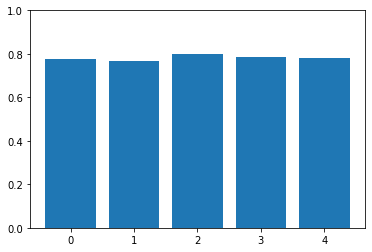

In [63]:
####################################
# size of the population
N_POP = 5
# number of iteration of selection
N_ITER = 5
# selection ratio
SELEC_RATIO = 0.6
# chance of mutation
CHANCE = 0.1
# number of fold for evaluation
K = 2
####################################
# we keep a param to receive
best_indiv = Param()
# initial population
population = generate_population(N_POP)
compute_fitness(
    train2_input, train2_target, train2_classes, population, K=2, verbose=True
)
compute_individuality(population)
for i in range(N_ITER):
    clear_output(wait=False)
    print("Population Progression: {} %".format(i / N_ITER * 100))
    plot_population(population)
    plt.pause(0.05)
    population = selection(population, selec_ratio=SELEC_RATIO)
    if population[0].score_mean > best_indiv.score_mean:
        best_indiv = population[0]
    population = breed(population, n_pop=N_POP, chance=CHANCE)
    compute_fitness(train2_input, train2_target, train2_classes, population, K=3)
    compute_individuality(population)

<div class="alert alert-block alert-info">
Once again, we compute the score on a bigger K-fold for consistent results
</div>

In [65]:
best_indiv.KFold(train2_input, train2_target, train2_classes, K=BIG_K, verbose=True)

--------------------Validation Accuracies for 10-fold:--------------------
Accuracy 1st network: 0.10 +- 0.07
Accuracy 2nd network: 0.12 +- 0.05
Accuracy comparison:  0.80 +- 0.05


tensor([0.8000, 0.8000, 0.7800, 0.8000, 0.8000, 0.7200, 0.9000, 0.8400, 0.8400,
        0.7200])

# Results